# Lymphocyte Detection using YoLOv5-small size.

In [9]:
# crean-up any folders from the previous run! 
#!rm -r images labels results setup yolov5/runs/detect yolov5/runs/train lymphocyte __pycache__

## Imports

In [3]:
import os
import shutil

import os.path as osp

from pathlib import Path
from tqdm import tqdm
from tqdm import tqdm_notebook

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns

import yaml

from utils import *
from geo_augmentations import *
from data_handling import *
from visualization import perform_subjective_evaluation
from evaluation import perform_objective_evaluation

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## main

In [4]:
# set your current directory as the root dir
root_dir = '.'

# give the path to your data directory -- absolute / relative
# Assuming your data is present in current direcory then 
data_dir = osp.join(root_dir, 'lymphocyte')

# set input-output paths, function sits in utils.py
io_paths = create_io_dirs(root_dir=root_dir)

# A: Creating test-data partition in advance
test_ratio = 0.10 # 10% of the total data
test_FileNames = split_test_set(ratio=test_ratio, paths=io_paths)

# B: Create extended data set using geometric augmentations
geometrical_augmentations(io_paths, test_FileNames)

# C: Create Train-Validation data split
train_ratio = 0.80 # 80% -20% of the remaining data
train_FileNames, tune_FileNames = split_train_valid_set(train_ratio=train_ratio, paths=io_paths)

# D: Re-arrange image data
move_data(io_paths=io_paths, train_files=train_FileNames, valid_files=tune_FileNames, test_files=test_FileNames)

# E: create info dataframes
df_data_info = create_info_dataframes(io_paths=io_paths, train_files=train_FileNames, valid_files=tune_FileNames, test_files=test_FileNames)

# F: Generate YOLO format annotations
bb_radii = 5 # literature (https://geertlitjens.nl/publication/swid-19/swid-19.pdf) says its about 10x10 px 
df_data_info = generate_YOLO_annotations(df_all=df_data_info, io_paths=io_paths, bb_radii=bb_radii)
df_data_info.to_csv('data_info.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 7076.61it/s]


## Model Training (YOLOv5)

In [5]:

!python yolov5/train.py --img 100 --batch 8 --epochs 45 --data yolov5/data/lymphocyte.yaml --cfg yolov5/models/yolov5s.yaml \
    --weights yolov5/yolov5s.pt --name yolov5s_lymphocyte --hyp yolov5/data/hyps/hyp.lymphocyte.yaml --cache


train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=yolov5/data/lymphocyte.yaml, hyp=yolov5/data/hyps/hyp.lymphocyte.yaml, epochs=45, batch_size=8, imgsz=100, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5s_lymphocyte, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 15 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-259-g7b80545 torch 1.10.2+cu102 CUDA:0 (NVIDIA TITAN Xp, 12187MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=5.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.

## Inference -- on all 100 images

In [6]:

!python yolov5/detect.py --img 100 --data yolov5/data/lymphocyte.yaml --source lymphocyte/data/ --weights yolov5/runs/train/yolov5s_lymphocyte/weights/best.pt \
    --conf-thres 0.4 --iou-thres 0.6 --save-txt --save-conf --name yolov5s_lymphocyte --line-thickness 1 --hide-labels --half


detect: weights=['yolov5/runs/train/yolov5s_lymphocyte/weights/best.pt'], source=lymphocyte/data/, data=yolov5/data/lymphocyte.yaml, imgsz=[100, 100], conf_thres=0.4, iou_thres=0.6, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolov5s_lymphocyte, exist_ok=False, line_thickness=1, hide_labels=True, hide_conf=False, half=True, dnn=False
YOLOv5 🚀 v6.0-259-g7b80545 torch 1.10.2+cu102 CUDA:0 (NVIDIA TITAN Xp, 12187MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Speed: 0.1ms pre-process, 5.7ms inference, 0.8ms NMS per image at shape (1, 3, 128, 128)
Results saved to yolov5/runs/detect/yolov5s_lymphocyte
100 labels saved to yolov5/runs/detect/yolov5s_lymphocyte/labels


## Performance -- evaluation

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 455.18it/s]


Confusion matrix plots saved at:
 ./results/performance_plots/train


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 442.93it/s]


Confusion matrix plots saved at:
 ./results/performance_plots/valid


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 390.94it/s]


Confusion matrix plots saved at:
 ./results/performance_plots/test


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 446.09it/s]


Confusion matrix plots saved at:
 ./results/performance_plots/org

Predicted masks saved at:
 ./results/masks_predicted.

Predicted & GT center comparison saved at:
 ./results/masks_comparison.

Predicted & GT center image overlay saved at at:
  ./results/masks_img_comparison.

Subjective results saved at at:
 ./results/comparison_images_masks.



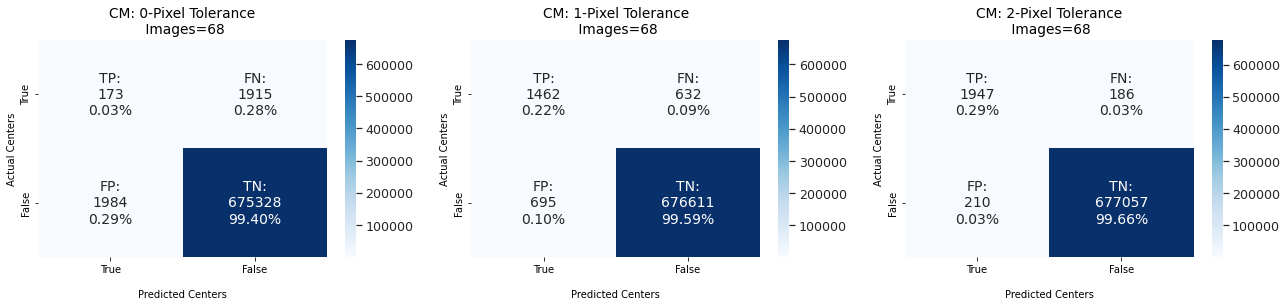

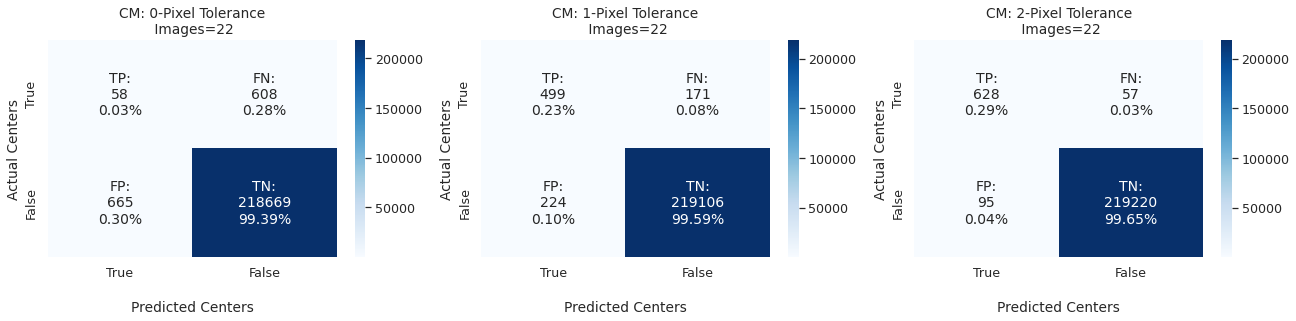

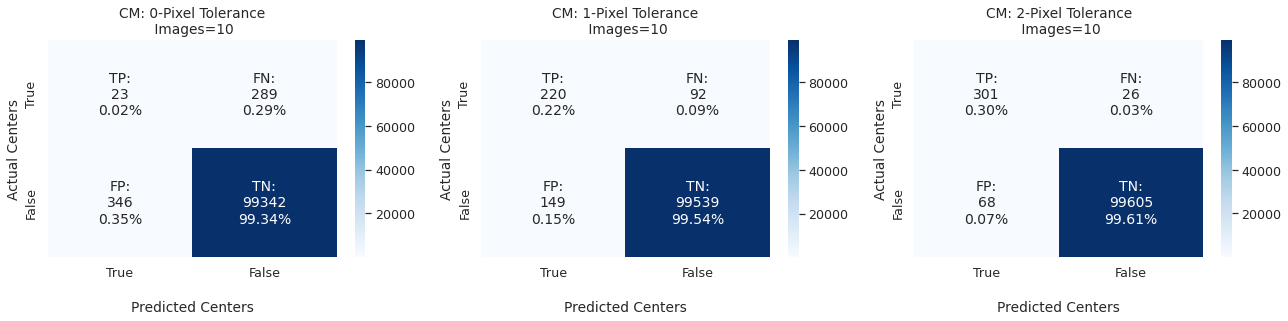

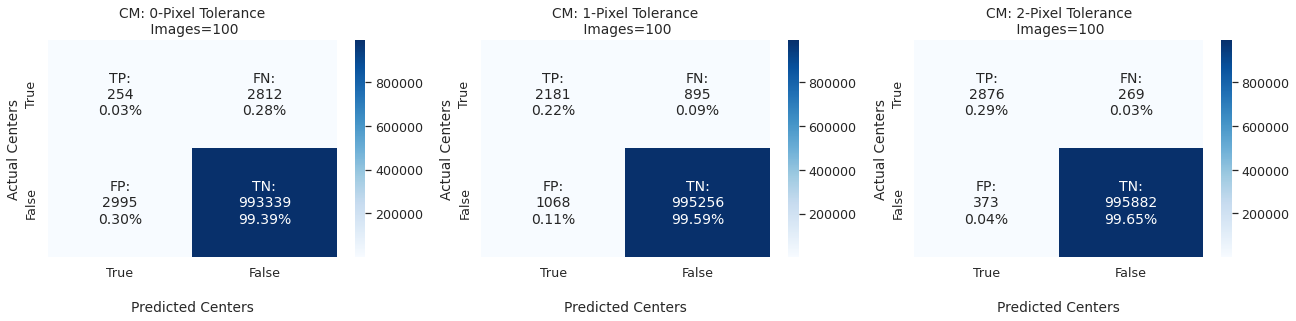

In [7]:

df_all = pd.read_csv('data_info.csv')
df_eval = perform_objective_evaluation(df_all=df_all, io_paths=io_paths)
perform_subjective_evaluation(df_all=df_all, io_paths=io_paths)


Plot saved at ./results/performance_overview.png


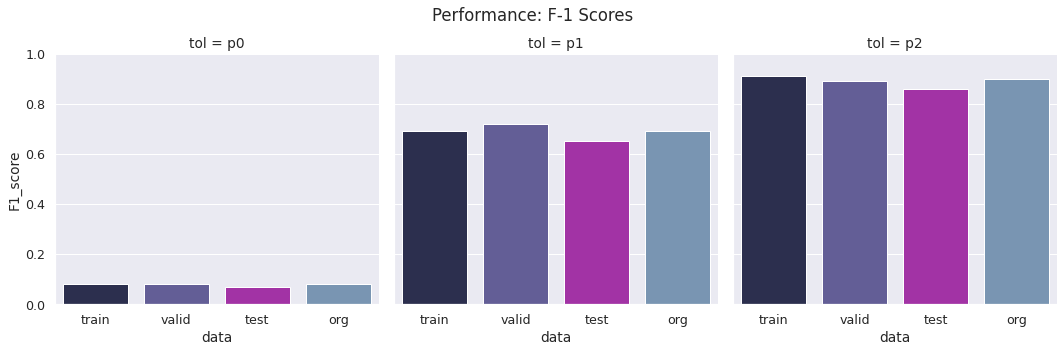

In [8]:
sns.axes_style('whitegrid')

fg = sns.catplot(data=df_eval, x='data', y='F1_score', col='tol', kind='bar', palette='bright', color='w')
fg.set(ylim=(0, 1.0))
fg.fig.subplots_adjust(top=0.85) 
fg.fig.suptitle(f'Performance: F-1 Scores (epochs = 45)')

op_path = './results/performance_overview.png'
plt.savefig(op_path, dpi=100, bbox_inches='tight', transparent=False)
print(f'Plot saved at {op_path}')

# End of code!